In [1]:
import os
import subprocess
import pandas as pd

import requests
import concurrent.futures
from bs4 import BeautifulSoup

In [2]:
output_Dir = os.path.join('/','home','arturo','Downloads','MERGE_INPE')

url_dir = 'https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY/'

# Default period 2018-2024
yy_s = 2018 
yy_e = 2018

In [3]:
num_workers = 20

In [4]:
def listFD(URL_base, ext=''):
    page = requests.get(URL_base).text
    soup = BeautifulSoup(page, 'html.parser')
    return [URL_base + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def download_url(url):
    print(f"Downloading {url}")
    filename = url.split('/')[-1]
    if os.path.isfile(os.path.join(output_Dir,filename)) == False:
        subprocess.run([
                        "wget",
                        url,
                        "-O",
                        os.path.join(output_Dir,filename)
                        ])

    else:
        print(f"File already exists: {filename}")
        if os.stat(os.path.join(output_Dir,filename)).st_size == 0:
            print(f"File exists but has zero bytes: {filename}")
            subprocess.run([
                            "wget",
                            url,
                            "-O",
                            os.path.join(output_Dir,filename)
                            ])


In [5]:
for yy in range(yy_s,yy_e+1):
    yy_list = []
    mm_list = []
    dd_list = []
    list_files = []
    if os.path.isfile(os.path.join(output_Dir,f'MERGE_{yy}.csv')) == False:
        for mm in range(1,13):
            for dd in range(1,32):
                URL_data = f'{url_dir}{yy}/{str(mm).zfill(2)}/{str(dd).zfill(2)}/'
                for file in listFD(URL_data, 'grib2'):
                    yy_list.append(yy)
                    mm_list.append(mm)
                    dd_list.append(dd)
                    list_files.append(file)

        df = pd.DataFrame({
                        'Year': yy_list,
                        'Month': mm_list,
                        'Day': dd_list,
                        'File': list_files
                        })
        df.to_csv(os.path.join(output_Dir,f'MERGE_{yy}.csv'), index=False)

    else:
        continue

In [11]:
for yy in range(yy_s,yy_e+1):
    print(yy)
    df_load = pd.read_csv(os.path.join(output_Dir,f'MERGE_{yy}.csv'))
    df_load = df_load.iloc[0:40] # Download 50 files for testing

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(download_url, df_load['File'].values)

2018
File already exists: MERGE_CPTEC_2018010100.grib2
File already exists: MERGE_CPTEC_2018010101.grib2
File already exists: MERGE_CPTEC_2018010102.grib2
File already exists: MERGE_CPTEC_2018010104.grib2
File already exists: MERGE_CPTEC_2018010105.grib2
File already exists: MERGE_CPTEC_2018010107.grib2
File already exists: MERGE_CPTEC_2018010103.grib2
File already exists: MERGE_CPTEC_2018010106.grib2
File already exists: MERGE_CPTEC_2018010111.grib2
File already exists: MERGE_CPTEC_2018010110.grib2
File already exists: MERGE_CPTEC_2018010108.grib2
File already exists: MERGE_CPTEC_2018010109.grib2
File already exists: MERGE_CPTEC_2018010112.grib2
File already exists: MERGE_CPTEC_2018010115.grib2
File already exists: MERGE_CPTEC_2018010114.grib2
File already exists: MERGE_CPTEC_2018010113.grib2
File already exists: MERGE_CPTEC_2018010121.grib2
File already exists: MERGE_CPTEC_2018010118.grib2
File already exists: MERGE_CPTEC_2018010116.grib2
File already exists: MERGE_CPTEC_2018010120.g

In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

DATA = xr.open_dataset(os.path.join(output_Dir,'MERGE_CPTEC_2018010213.grib2'))

In [8]:
lat = DATA.latitude
lon = DATA.longitude
lon2d, lat2d = np.meshgrid(lon, lat)
PRE = DATA.rdp.values

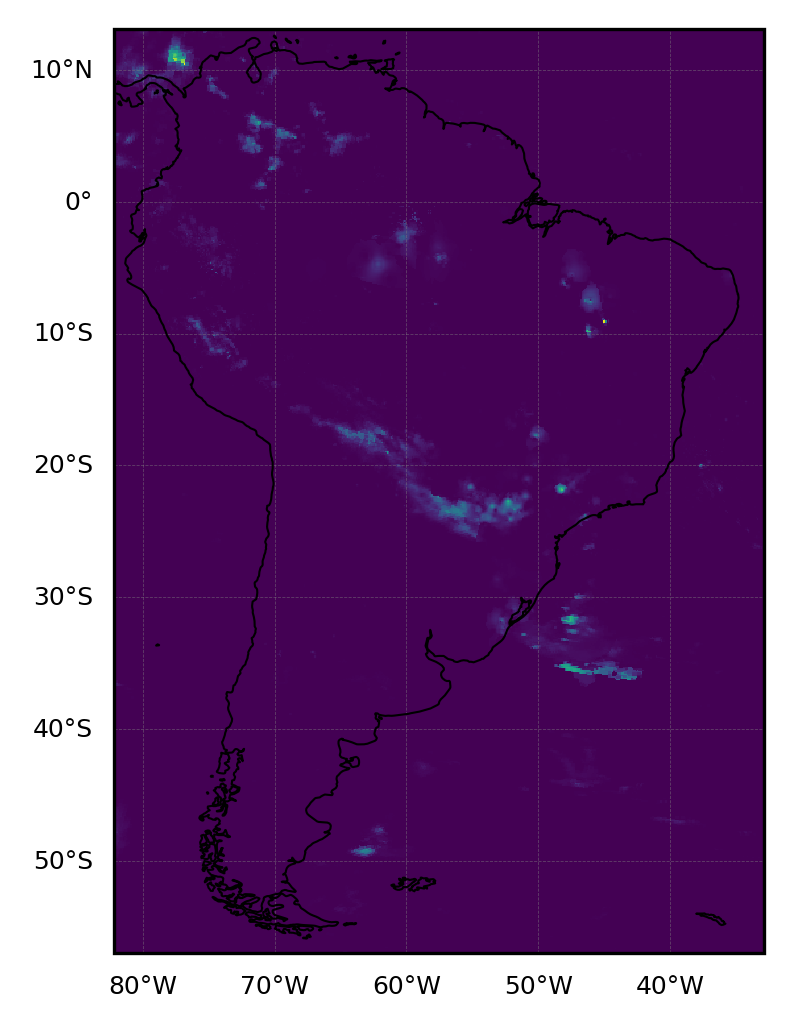

In [9]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.5,color='black',zorder=4)
ax1.pcolormesh(lon2d, lat2d, PRE)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}